In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Importing Libraries

In [2]:
!pip install statsmodels

In [3]:
import sys
!{sys.executable} -m pip install missingno

In [4]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import lazypredict
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA


# Reading Data

In [5]:
#reading data
df= pd.read_csv('input/GCB2022v27_MtCO2_flat.csv')

<Axes: >

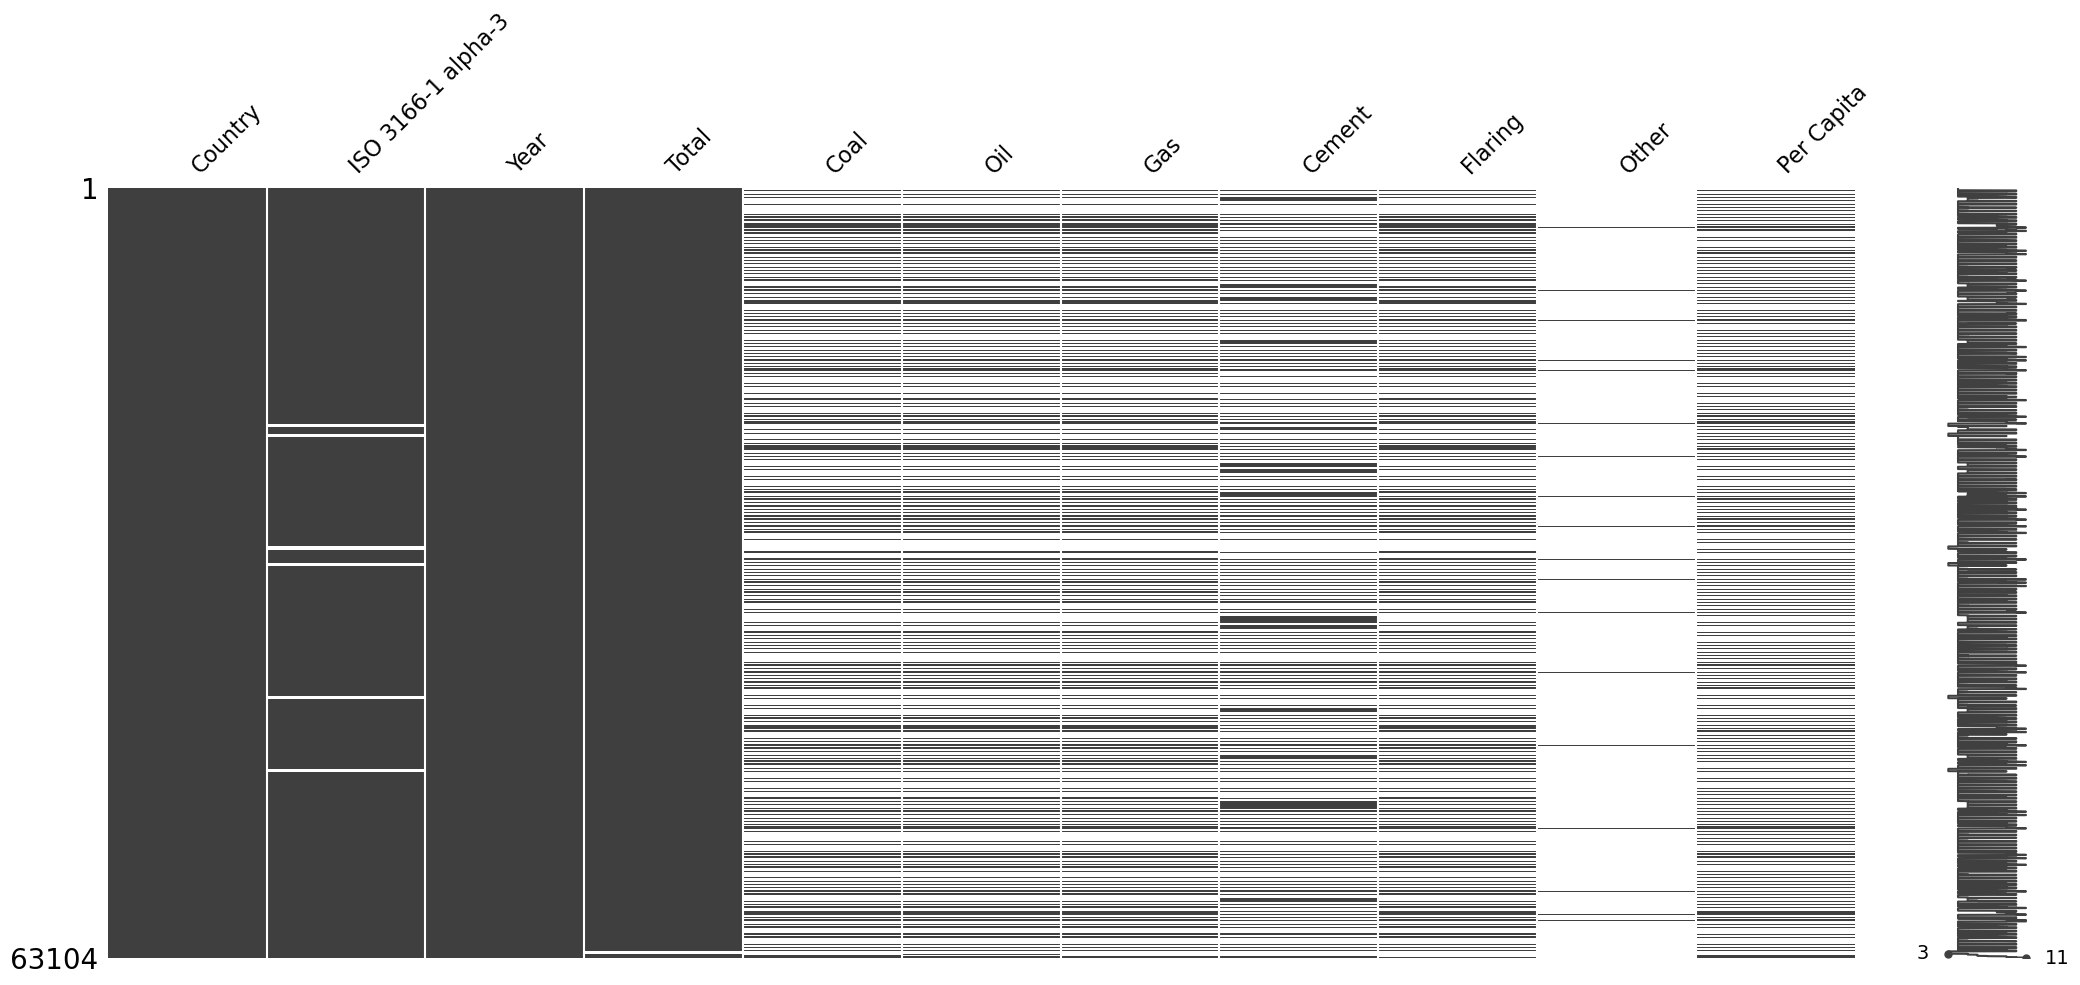

In [6]:
#checking missing values
msno.matrix(df)

# Basic Features About the Dataset


In [7]:
#dropping years less than 1950
df.drop(df[df['Year'] < 1950].index, inplace = True)

# Check for Missing Values

<Axes: >

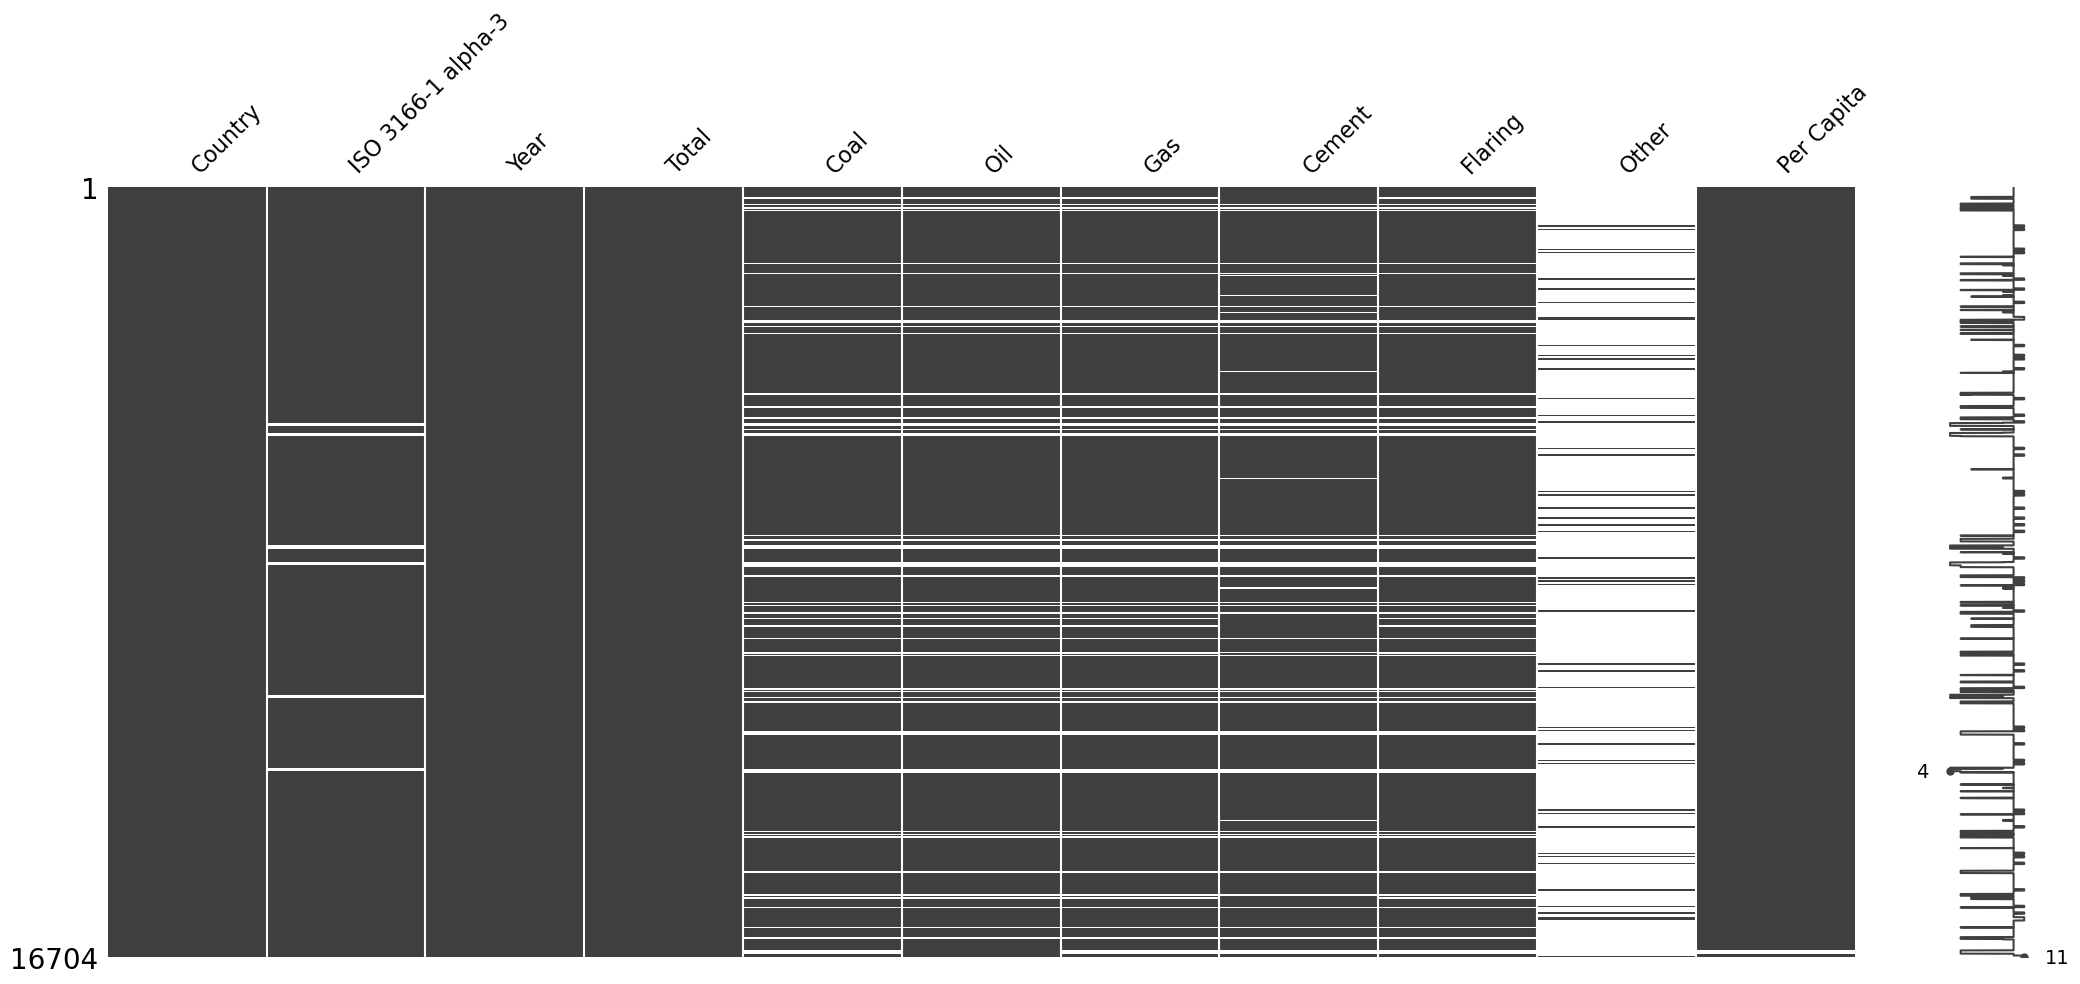

In [8]:
msno.matrix(df)

In [9]:
#checking the columns
df.columns

Index(['Country', 'ISO 3166-1 alpha-3', 'Year', 'Total', 'Coal', 'Oil', 'Gas',
       'Cement', 'Flaring', 'Other', 'Per Capita'],
      dtype='object')

# Getting to Know the Data

In [10]:
#converting countries to list
countries=list(df["Country"].unique())


In [11]:
df.shape

(16704, 11)

In [12]:
missing_columns= ['Coal', 'Oil', 'Gas',
       'Cement', 'Flaring', 'Other']
df.dtypes

Country                object
ISO 3166-1 alpha-3     object
Year                    int64
Total                 float64
Coal                  float64
Oil                   float64
Gas                   float64
Cement                float64
Flaring               float64
Other                 float64
Per Capita            float64
dtype: object

# Feature Engineering

**We would be filling missing data with the mean . The problem with using pandas to fill mean would be that it would only fill the mean of the entire column. For example, for the missing data in afganistan, it would fill from the mean of the countries which includes developed countries such as USA, China etc. To work Around this, we would be grouping the data by the mean for each country and then fill the missing data.**

In [13]:
#Getting the mean of Each country
coal_mean=df.groupby('Country')['Coal'].mean()
oil_mean=df.groupby('Country')['Oil'].mean()
gas_mean=df.groupby('Country')['Gas'].mean()
cement_mean=df.groupby('Country')['Cement'].mean()
flaring_mean=df.groupby('Country')['Flaring'].mean()
other_mean=df.groupby('Country')['Other'].mean()
per_capita_mean= df.groupby('Country')['Per Capita'].mean()
#Setting the Index
coal_mean.index = countries
oil_mean.index = countries
gas_mean.index = countries
cement_mean.index = countries
flaring_mean.index = countries
other_mean.index = countries
per_capita_mean.index = countries
#Converting to Dictionary
coal_mean=coal_mean.to_dict()
oil_mean=oil_mean.to_dict()
gas_mean=gas_mean.to_dict()
cement_mean= cement_mean.to_dict()
flaring_mean=flaring_mean.to_dict()
other_mean=other_mean.to_dict()
per_capita_mean= per_capita_mean.to_dict()

In [14]:
#fillin missing values with the mean of that country and the type of fuel
df.Coal = df.Coal.fillna(df.Country.map(coal_mean))
df.Oil = df.Oil.fillna(df.Country.map(oil_mean))
df.Gas = df.Gas.fillna(df.Country.map(gas_mean))
df.Cement = df.Cement.fillna(df.Country.map(cement_mean))
df.Flaring = df.Flaring.fillna(df.Country.map(flaring_mean))
df.Other = df.Other.fillna(df.Country.map(other_mean))
df['Per Capita'].fillna(df.Country.map(per_capita_mean), inplace=True)

<Axes: >

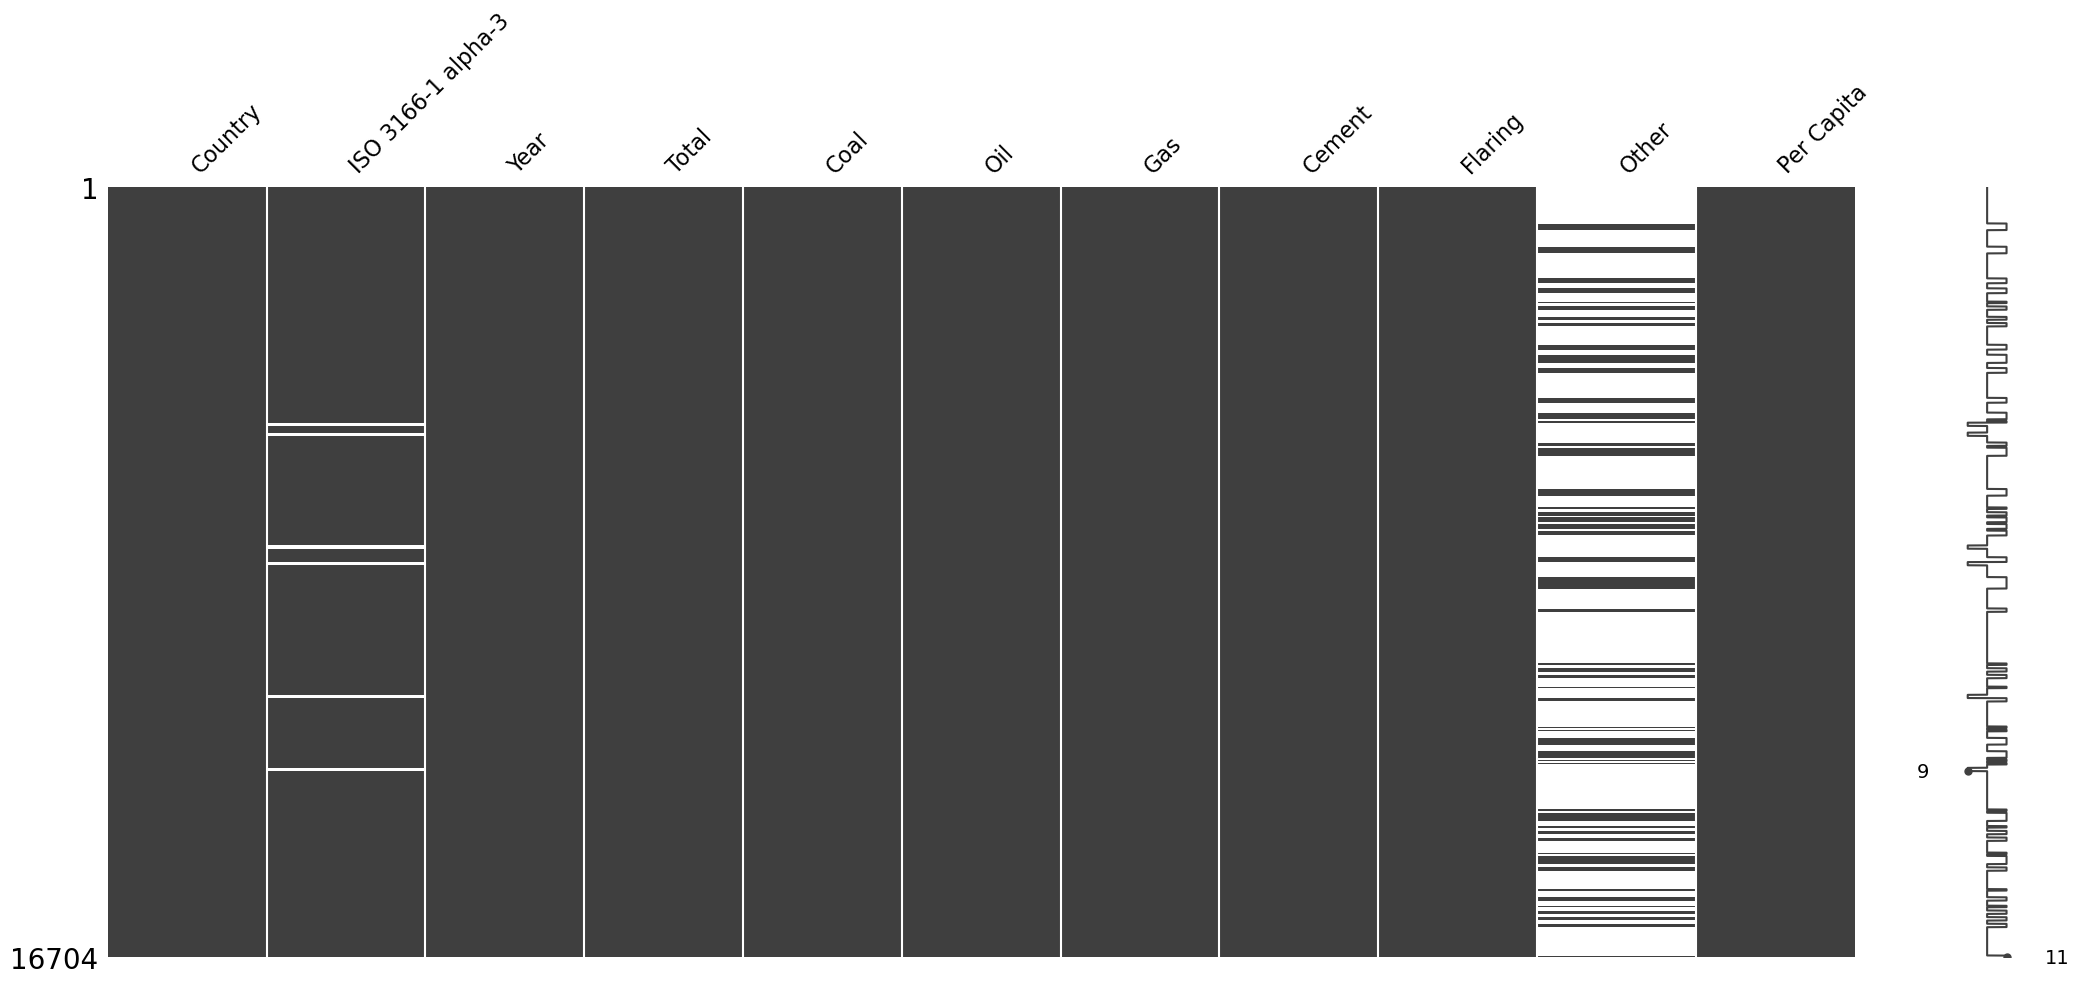

In [15]:
msno.matrix(df)

In [16]:
df

Country ISO 3166-1 alpha-3  Year         Total          Coal  \
200    Afghanistan                AFG  1950      0.084272      0.021068   
201    Afghanistan                AFG  1951      0.091600      0.025648   
202    Afghanistan                AFG  1952      0.091600      0.031708   
203    Afghanistan                AFG  1953      0.106256      0.037949   
204    Afghanistan                AFG  1954      0.106256      0.042502   
...            ...                ...   ...           ...           ...   
63099       Global                WLD  2017  36096.739276  14506.973805   
63100       Global                WLD  2018  36826.506600  14746.830688   
63101       Global                WLD  2019  37082.558969  14725.978025   
63102       Global                WLD  2020  35264.085734  14174.564010   
63103       Global                WLD  2021  37123.850352  14979.598083   

                Oil          Gas       Cement     Flaring       Other  \
200        0.063204     0.000000     0.000000    0.000000         NaN   
201        0.065952     0.000000     0.000000    0.000000         NaN   
202        0.059892     0.000000     0.000000    0.000000         NaN   
203        0.068307     0.000000     0.000000    0.000000         NaN   
204        0.063754     0.000000     0.000000    0.000000         NaN   
...             ...          ...          ...         ...         ...   
63099  12242.627935  7144.928128  1507.923185  391.992176  302.294047   
63100  12266.016285  7529.846784  1569.218392  412.115746  302.478706   
63101  12345.653374  7647.528220  1617.506786  439.253991  306.638573   
63102  11191.808551  7556.290283  1637.537532  407.583673  296.301685   
63103  11837.159116  7921.829472  1672.592372  416.525563  296.145746   

       Per Capita  
200      0.011266  
201      0.012098  
202      0.011946  
203      0.013685  
204      0.013511  
...           ...  
63099    4.749682  
63100    4.792753  
63101    4.775633  
63102    4.497423  
63103    4.693699  

[16704 rows x 11 columns]

In [17]:
mean_value=df['Other'].mean()
  
# Replace NaNs in column S2 with the
# mean of values in the same column
df['Other'].fillna(value=mean_value, inplace=True)
df.isna().sum()

Country                 0
ISO 3166-1 alpha-3    432
Year                    0
Total                   0
Coal                    0
Oil                     0
Gas                     0
Cement                  0
Flaring                 0
Other                   0
Per Capita              0
dtype: int64

<Axes: >

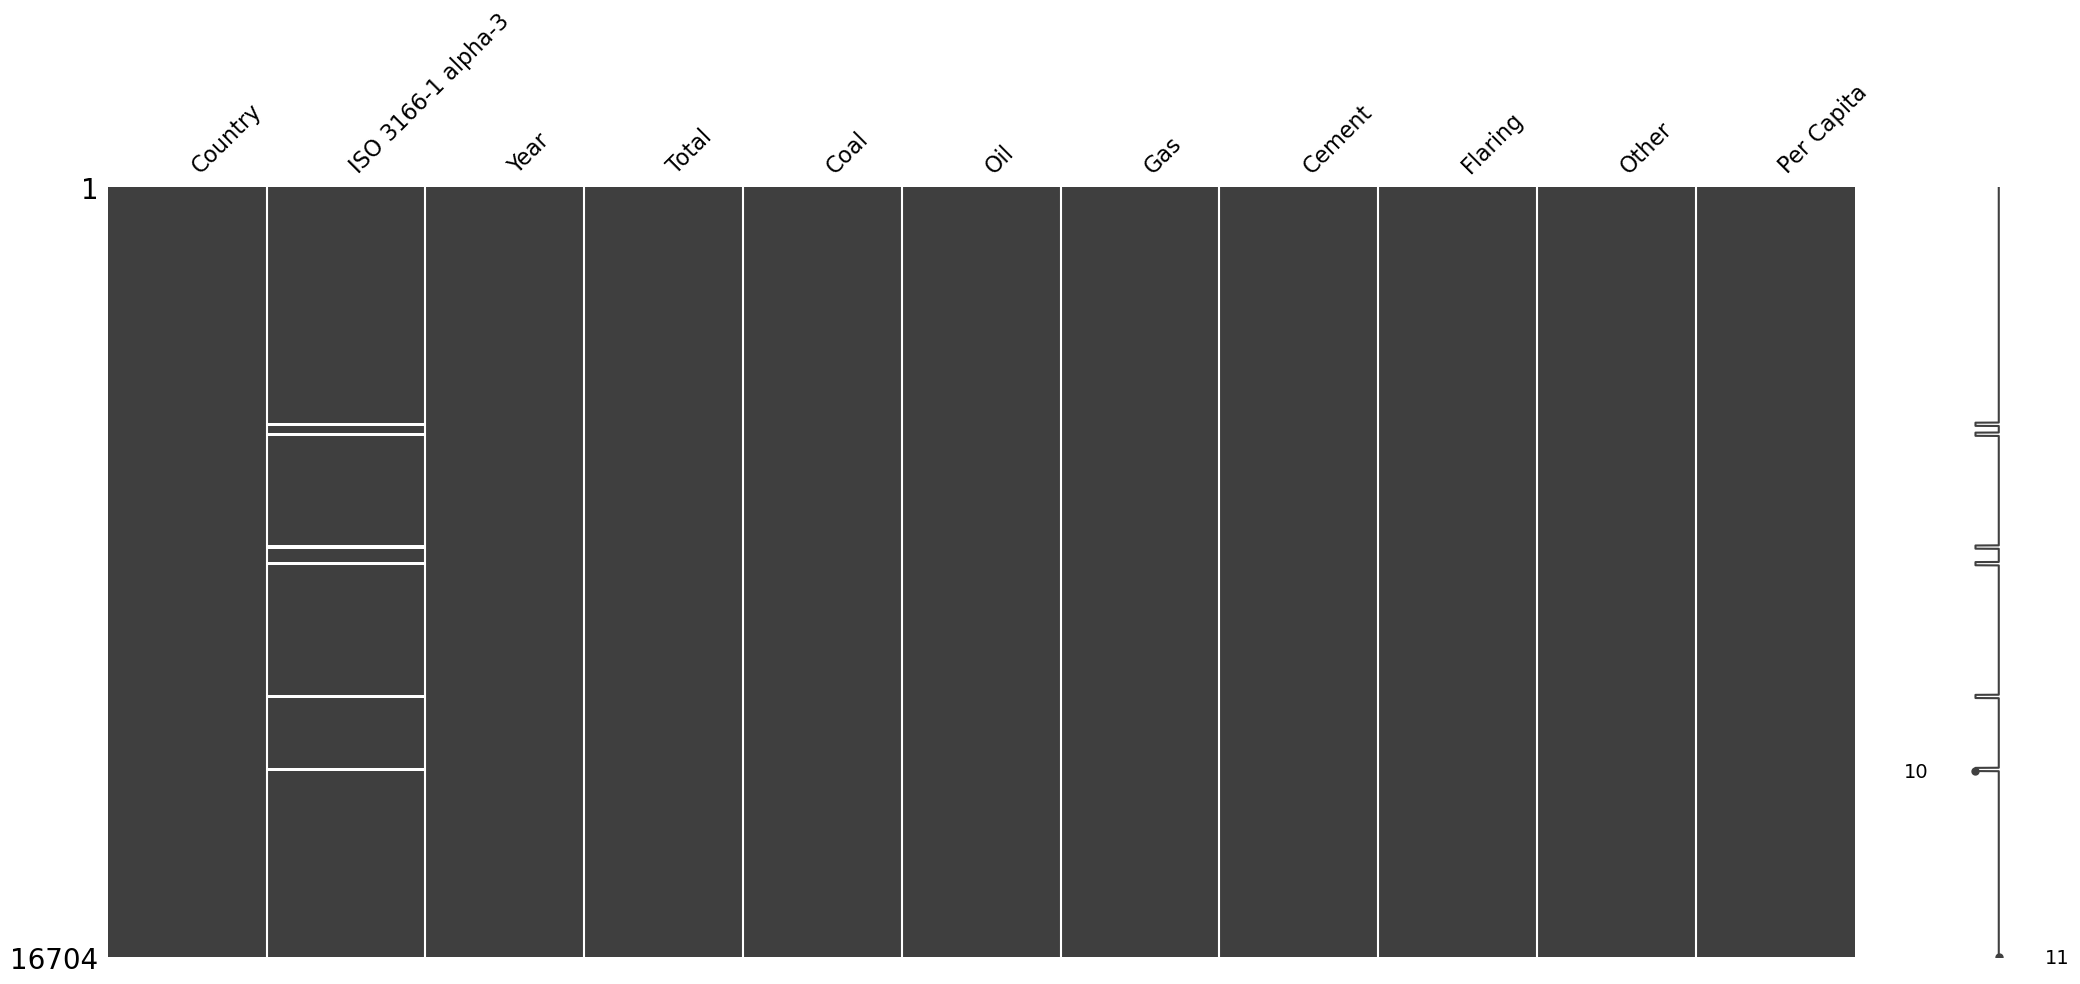

In [18]:
msno.matrix(df)

In [19]:
#removing the values of the world
glob= df[df['ISO 3166-1 alpha-3'] == 'WLD']

In [20]:
#droppin missing iso values columns
df.drop(df[df['ISO 3166-1 alpha-3'] == 'WLD'].index, inplace = True)

In [21]:
#top 100 countries in each fuel category
Coal_mean=df.groupby(['ISO 3166-1 alpha-3','Country'])['Coal'].mean().sort_values(ascending=False)[0:100].reset_index()
Oil_mean=df.groupby(['ISO 3166-1 alpha-3','Country'])['Oil'].mean().sort_values(ascending=False)[0:100].reset_index()
Gas_mean=df.groupby(['ISO 3166-1 alpha-3','Country'])['Gas'].mean().sort_values(ascending=False)[0:100].reset_index()
Cement_mean=df.groupby(['ISO 3166-1 alpha-3','Country'])['Cement'].mean().sort_values(ascending=False)[0:100].reset_index()
Flaring_mean=df.groupby(['ISO 3166-1 alpha-3','Country'])['Flaring'].mean().sort_values(ascending=False)[0:100].reset_index()
Other_mean=df.groupby(['ISO 3166-1 alpha-3','Country'])['Other'].mean().sort_values(ascending=False)[0:100].reset_index()
Total_mean=df.groupby(['ISO 3166-1 alpha-3','Country'])['Total'].mean().sort_values(ascending=False)[0:100].reset_index()


In [22]:
categories=['Coal', 'Oil', 'Gas',
       'Cement', 'Flaring', 'Other','Total']
len(categories)

7

In [23]:
df_cat= ['Coal_mean','Oil_mean','Gas_mean','Cement_mean','Flaring_mean','Other_mean','Total_mean']

In [24]:
def chlorepath(data,color):
    fig=px.choropleth(data, locations="ISO 3166-1 alpha-3",
                    color= color, 
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)
    fig.show()

In [25]:
#getting the top 10 countries in each category
Coal_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Coal'].mean().sort_values(ascending=False)[0:10].reset_index()
Oil_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Oil'].mean().sort_values(ascending=False)[0:10].reset_index()
Gas_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Gas'].mean().sort_values(ascending=False)[0:10].reset_index()
Cement_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Cement'].mean().sort_values(ascending=False)[0:10].reset_index()
Flaring_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Flaring'].mean().sort_values(ascending=False)[0:10].reset_index()
Other_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Other'].mean().sort_values(ascending=False)[0:10].reset_index()
Total_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Total'].mean().sort_values(ascending=False)[0:10].reset_index()
Per_Capita_mean_10=df.groupby(['ISO 3166-1 alpha-3','Country'])['Per Capita'].mean().sort_values(ascending=False)[0:10].reset_index()
Year_mean_10_pc=df.groupby(['Year'])['Per Capita'].mean().sort_values(ascending=False)[0:10].reset_index()
Year_mean_10_total=df.groupby(['Year'])['Total'].mean().sort_values(ascending=False)[0:10].reset_index()

# Pie Chart to Show top 10 countries by Coal Emissions

In [26]:
fig1= px.pie(Coal_mean_10,values='Coal',names='Country',title= "Top 10 Countries by Coal Emission")
fig1.show()

# Pie Chart to Show top 10 countries by Oil Emissions

In [27]:
fig2= px.pie(Oil_mean_10,values='Oil',names='Country',title= " Top 10 Countries by Oil Emission")
fig2.show()

# Pie Chart to Show top 10 countries by Gas Emissions

In [28]:
fig3= px.pie(Gas_mean_10,values='Gas',names='Country',title= " Top 10 Countries by Gas Emission")
fig3.show()

# Pie Chart to Show top 10 countries by Cement Emissions

In [29]:
fig4= px.pie(Cement_mean_10,values='Cement',names='Country',title= " Top 10 Countries by Cement Emission")
fig4.show()

# Pie Chart to Show top 10 countries by Flaring Emissions

In [30]:
fig5= px.pie(Flaring_mean_10,values='Flaring',names='Country',title= " Top 10 Countries by Flaring Consumption")
fig5.show()

# Pie Chart to Show top 10 countries by Total Emissions

In [31]:
fig6= px.pie(Other_mean_10,values='Other',names='Country',title= "Top 10 Countries by Total Emission")
fig6.show()

# Pie Chart to Show top 10 countries by Coal Emissions

In [32]:
fig7= px.pie(Per_Capita_mean_10,values='Per Capita',names='Country',title= "Top 10 Countries by Per Capita Emission")
fig7.show()

# Pie Chart to Show top 10 Years of Highest per capita emission

In [33]:
fig8= px.pie(Year_mean_10_pc,values='Per Capita',names='Year',title= "Top 10 Years of Highest Per Capita Emission")
fig8.show()

# Pie Chart to Show top 10 Years of Highest Total mission

In [34]:
fig9= px.pie(Year_mean_10_total,values='Total',names='Year',title= "Top 10 Years of Highest Total Emission")
fig9.show()

# Chlorepath of top 100 countries by Coal Emission

In [35]:
#top 100 countries by Coal Emission
fig10=chlorepath(Coal_mean,'Coal')

# Chlorepath of top 100 countries by Oil Emission

In [36]:
#top 100 countries by Oil Emission
fig11= chlorepath(Oil_mean,'Oil')

# Chlorepath of top 100 countries by Gas Emission

In [37]:
#top 100 countries by Gas Emission
fig12= chlorepath(Gas_mean,'Gas')

# Chlorepath of top 100 countries by Total Emission

In [38]:
#top 100 countries by Total Emission
fig13=chlorepath(Total_mean,'Total')

# Chlorepath of top 100 countries by Per Capita Emission

In [39]:
#top 100 countries by Per Capita Emission
fig14=chlorepath(Per_Capita_mean_10,'Per Capita')

# Trend Plot of Per Capita Emission over the years

In [40]:
Year_mean_trend_pc=df.groupby(['Year'])['Per Capita'].mean().reset_index()
Year_mean_trend_total=df.groupby(['Year'])['Total'].mean().reset_index()

In [41]:
#trend of total emission over the years
fig15 = px.line(Year_mean_trend_pc, x="Year", y="Per Capita")
fig15.update_xaxes(rangeslider_visible=True)
fig15.show()


**Use the range slider to zoom through the respective years of intrest**

In [42]:
#trend of per capita emission over the years
fig16 = px.line(Year_mean_trend_total, x="Year", y="Total")
fig16.update_xaxes(rangeslider_visible=True)
fig16.show()

# MODEL BUILDING- TIME SERIES

<Axes: >

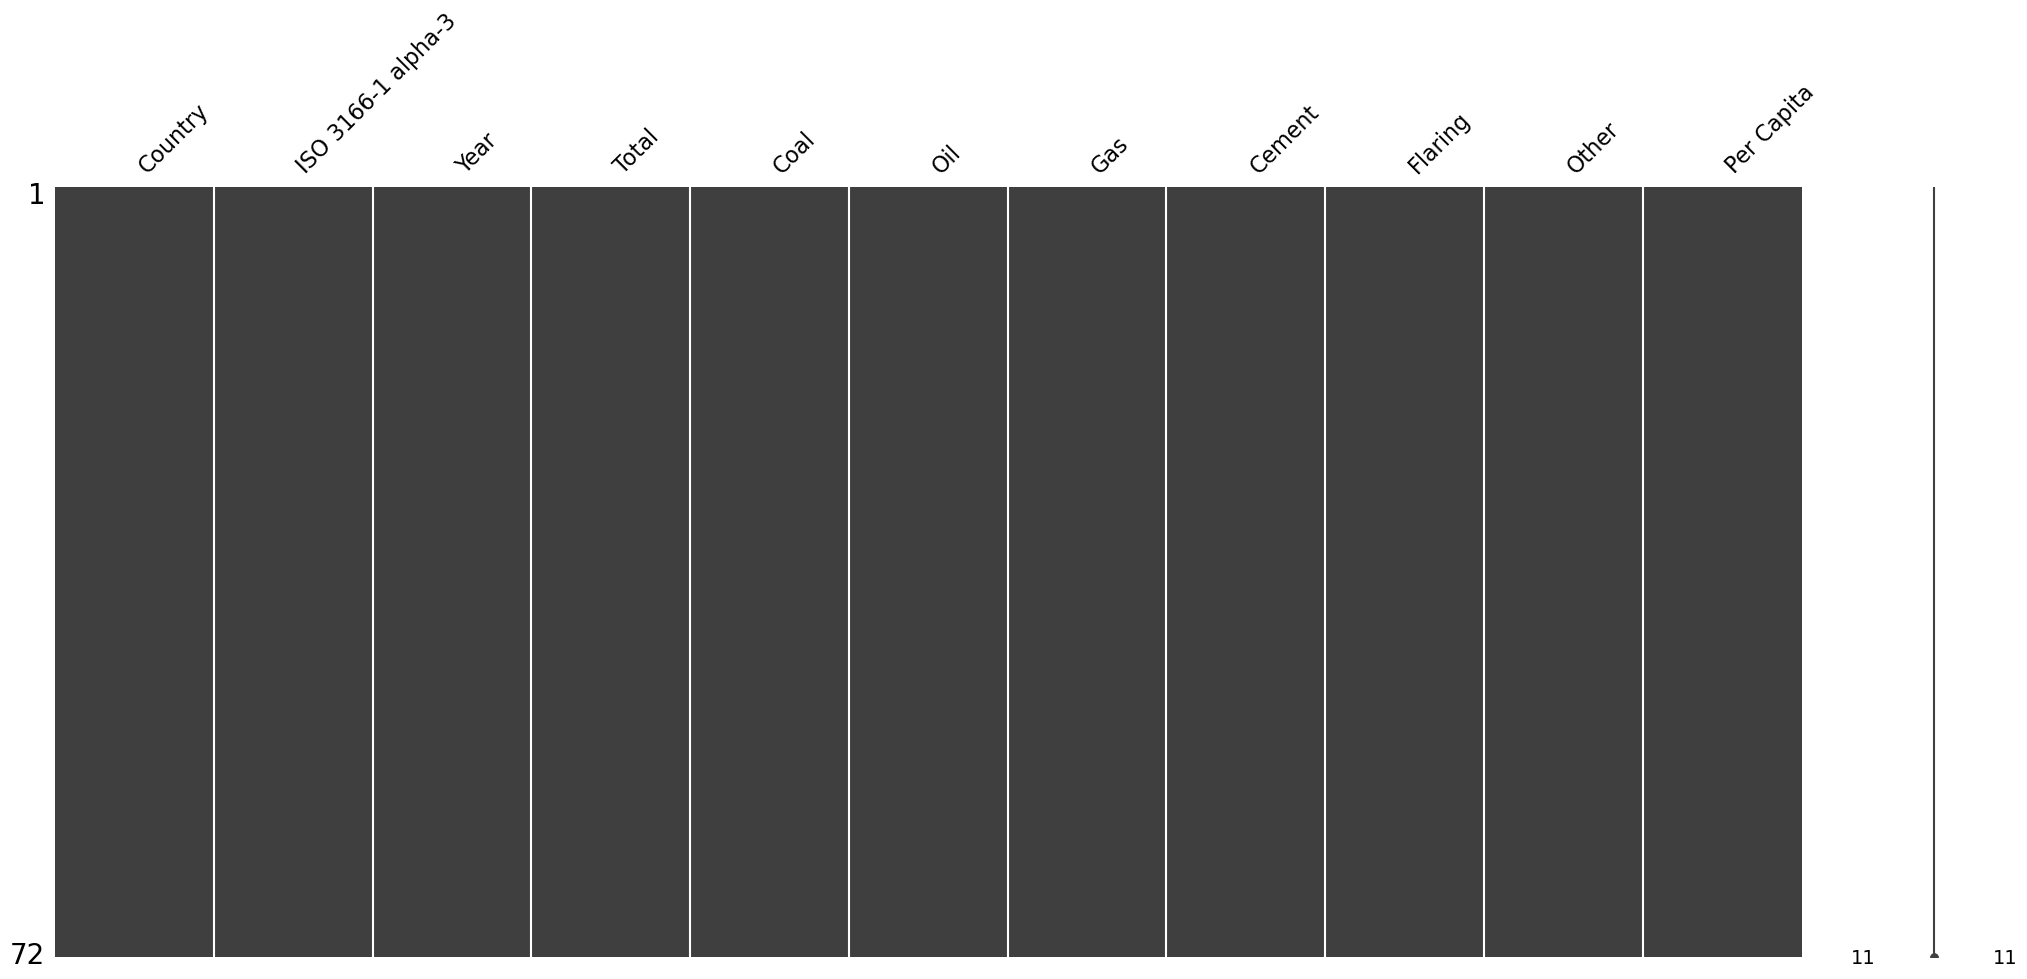

In [43]:
#checking the missing values in the glob data
msno.matrix(glob)

In [44]:
#checking the columns
glob.columns

Index(['Country', 'ISO 3166-1 alpha-3', 'Year', 'Total', 'Coal', 'Oil', 'Gas',
       'Cement', 'Flaring', 'Other', 'Per Capita'],
      dtype='object')

In [45]:
#checking the types of data in the columns
glob.dtypes

Country                object
ISO 3166-1 alpha-3     object
Year                    int64
Total                 float64
Coal                  float64
Oil                   float64
Gas                   float64
Cement                float64
Flaring               float64
Other                 float64
Per Capita            float64
dtype: object

In [46]:
glob.sample(5)

Country ISO 3166-1 alpha-3  Year         Total          Coal  \
63032  Global                WLD  1950   6003.271922   3856.215025   
63096  Global                WLD  2014  35577.534774  15051.512770   
63073  Global                WLD  1991  23244.805747   8604.035333   
63048  Global                WLD  1966  11866.933973   5351.301404   
63066  Global                WLD  1984  19664.753809   7668.797447   

                Oil          Gas       Cement     Flaring       Other  \
63032   1648.309543   353.156200    66.978938   73.624416   11.207946   
63096  11678.782147  6654.555376  1499.912273  387.901908  304.870299   
63073   9723.429325  3909.677268   507.750603  282.964847  216.948371   
63048   4761.952960  1339.839514   233.053105  144.566086   11.207946   
63066   8328.840383  3010.425483   417.702984  186.751322   11.207946   

       Per Capita  
63032    2.401960  
63096    4.847727  
63073    4.299621  
63048    3.483700  
63066    4.117552

In [47]:
#setting year as the index for the dataframe
glob.index= glob.Year
glob.sample(5)

Country ISO 3166-1 alpha-3  Year         Total          Coal  \
Year                                                                
2019  Global                WLD  2019  37082.558969  14725.978025   
1960  Global                WLD  1960   9387.668809   5152.557491   
1966  Global                WLD  1966  11866.933973   5351.301404   
1980  Global                WLD  1980  19501.263339   7024.128811   
1959  Global                WLD  1959   8856.221171   4948.027578   

               Oil          Gas       Cement     Flaring       Other  \
Year                                                                   
2019  12345.653374  7647.528220  1617.506786  439.253991  306.638573   
1960   3126.443989   834.527332   157.492595   89.140213   11.207946   
1966   4761.952960  1339.839514   233.053105  144.566086   11.207946   
1980   8951.775558  2758.101427   402.619608  316.435558   11.207946   
1959   2904.648763   758.226391   145.336357   91.693532   11.207946   

      Per Capita  
Year              
2019    4.775633  
1960    3.109289  
1966    3.483700  
1980    4.388215  
1959    2.981599

In [48]:
#dropping the irrelevant columns
glob.drop(['ISO 3166-1 alpha-3','Year','Country'], axis=1, inplace=True)

In [49]:
glob.sample(5)

Total          Coal           Oil          Gas       Cement  \
Year                                                                       
1982  18884.487014   7126.512351   8345.175954  2731.273279   400.937145   
2020  35264.085734  14174.564010  11191.808551  7556.290283  1637.537532   
1973  17086.192450   5862.084877   8225.937763  2203.889720   340.511491   
1972  16228.729199   5693.585165   7766.613848  2052.040538   321.547321   
1963  10271.654811   5109.542067   3806.972687  1046.822412   186.060077   

         Flaring       Other  Per Capita  
Year                                      
1982  235.574963   11.207946    4.098209  
2020  407.583673  296.301685    4.497423  
1973  402.141515   11.207946    4.358443  
1972  346.870011   11.207946    4.220954  
1963   90.506188   11.207946    3.214132

In [50]:
#checking the shape of the data
glob.shape

(72, 8)

In [51]:
#selecting only total column
glob_total= glob.iloc[:, :1]
glob_total

Total
Year              
1950   6003.271922
1951   6379.796307
1952   6465.726953
1953   6647.763209
1954   6789.968651
...            ...
2017  36096.739276
2018  36826.506600
2019  37082.558969
2020  35264.085734
2021  37123.850352

[72 rows x 1 columns]

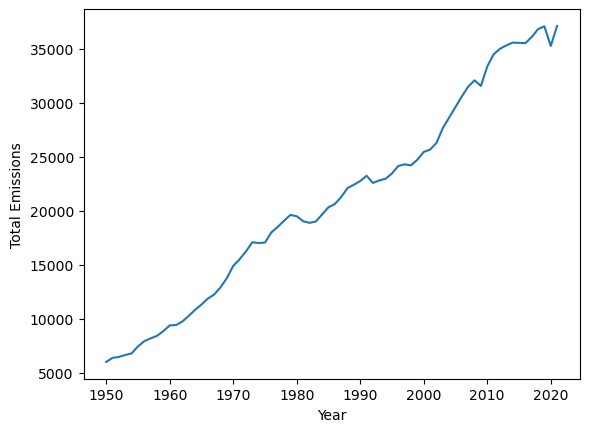

In [52]:
plt.plot(glob_total)
plt.ylabel("Total Emissions")
plt.xlabel("Year")
plt.show()


In [53]:
#performing dicky fuller test to check if the data is covariance stationery
for i in range(1,13,1):
    adf = st.adfuller(x=glob_total, regression="ct", maxlag=i)
    print("adf:", adf[0], "adf_pvalue:", adf[1])

adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -2.0012428302183385 adf_pvalue: 0.6007565751056425
adf: -3.242119295719277 adf_pvalue: 0.07633087027487469
adf: -3.242119295719277 adf_pvalue: 0.07633087027487469


**Inference:-Time series is not covariance stationery, the p value is greater than 5%.
A time series can be applied only to covariance stationery time series**

# Making Data Covariance Stationery

In [54]:
#shifting the data by 1 period and checking the distribution
glob_total['total_diff'] = glob_total['Total'] - glob_total['Total'].shift(1)

<Axes: xlabel='Year'>

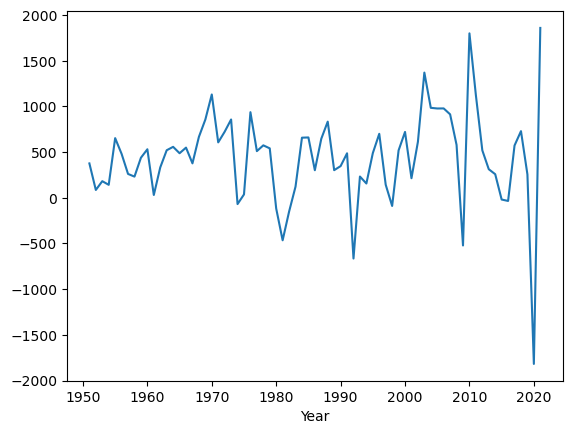

In [55]:
#Visaulaising the Distribution
glob_total['total_diff'].dropna().plot()

In [56]:
glob_total.head()

Total  total_diff
Year                         
1950  6003.271922         NaN
1951  6379.796307  376.524385
1952  6465.726953   85.930646
1953  6647.763209  182.036256
1954  6789.968651  142.205442

In [57]:
glob_total_temp= glob_total[['total_diff']]
glob_total_temp.dropna(inplace=True)

In [58]:
#performing dicky fuller test to check if the data is covariance stationery

for i in range(1,13,1):
    adf = st.adfuller(x=glob_total_temp, regression="ct", maxlag=i)
    print("lag:", i,"adf:", adf[0], "adf_pvalue:", adf[1])

lag: 1 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 2 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 3 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 4 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 5 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 6 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 7 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 8 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 9 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 10 adf: -7.493103048486838 adf_pvalue: 1.0570708155589803e-09
lag: 11 adf: -2.6480127501424753 adf_pvalue: 0.25829509229279957
lag: 12 adf: -3.022553722256728 adf_pvalue: 0.12588425933292097


**Inference:-Time series is not covariance stationery, the p value is greater than 5%**

In [59]:
# Calculate the square root 
glob_total['adj_sqrt'] = np.sqrt(glob_total['Total'])

<Axes: xlabel='Year'>

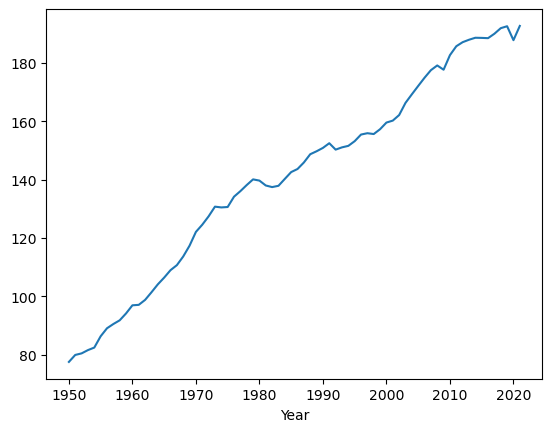

In [60]:
# Visualizing the data 
glob_total['adj_sqrt'].dropna().plot()

<Axes: xlabel='Year'>

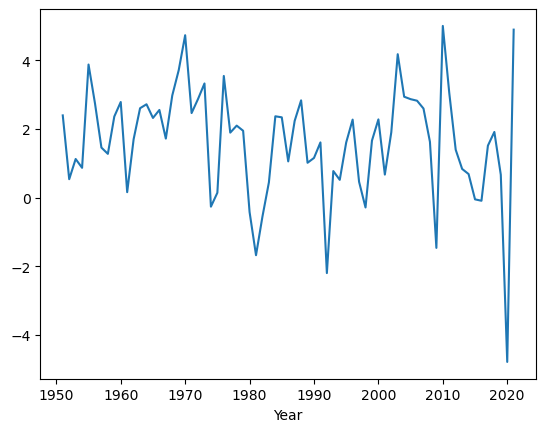

In [61]:
# Square root difference by 1 period
glob_total['adj_sqrt_diff'] = glob_total['adj_sqrt'] - glob_total['adj_sqrt'].shift(1)
glob_total['adj_sqrt_diff'].dropna().plot()

In [62]:
glob_total_temp1= glob_total[['adj_sqrt_diff']]
glob_total_temp1.dropna(inplace=True)

In [63]:
#performing dicky fuller test to check if the data is covariance stationery
for i in range(1,13,1):
    adf = st.adfuller(x=glob_total_temp1, regression="ct", maxlag=i)
    print("lag:", i,"adf:", adf[0], "adf_pvalue:", adf[1])

lag: 1 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 2 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 3 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 4 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 5 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 6 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 7 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 8 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 9 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 10 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 11 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08
lag: 12 adf: -6.958804626183896 adf_pvalue: 1.750886356566975e-08


**Inference:-Time series is not covariance stationery, the p value is greater than 5%**

In [64]:
# Calculating rolling mean
glob_total['roll12'] = glob_total['Total'].rolling(window = 12).mean()

<Axes: xlabel='Year'>

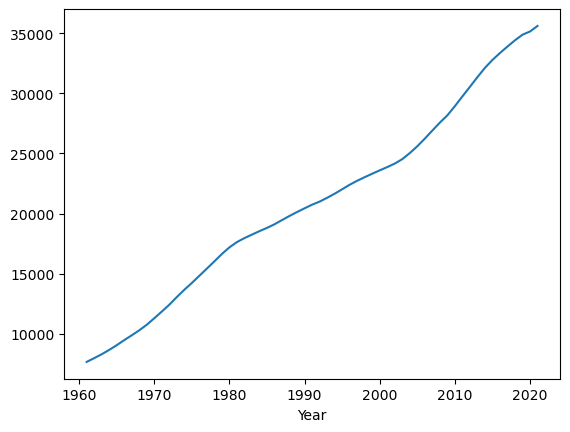

In [65]:
#visualizing the data
glob_total['roll12'].dropna().plot()

In [66]:
glob_total_temp2= glob_total[['roll12']]
glob_total_temp2.dropna(inplace=True)

In [67]:
#performing dicky fuller test to check if the data is covariance stationery
for i in range(1,13,1):
    adf = st.adfuller(x=glob_total_temp2, regression="ct", maxlag=i)
    print("lag:", i,"adf:", adf[0], "adf_pvalue:", adf[1])

lag: 1 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 2 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 3 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 4 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 5 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 6 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 7 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 8 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 9 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 10 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 11 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902
lag: 12 adf: -3.56952596219036 adf_pvalue: 0.03251934854550902


**Inference:-Time series is  covariance stationery, the p value is less than 5%**
We Choose the roll 12 as mens to make the data covariance stationery, as the other transformations do not make the data covariance stationery

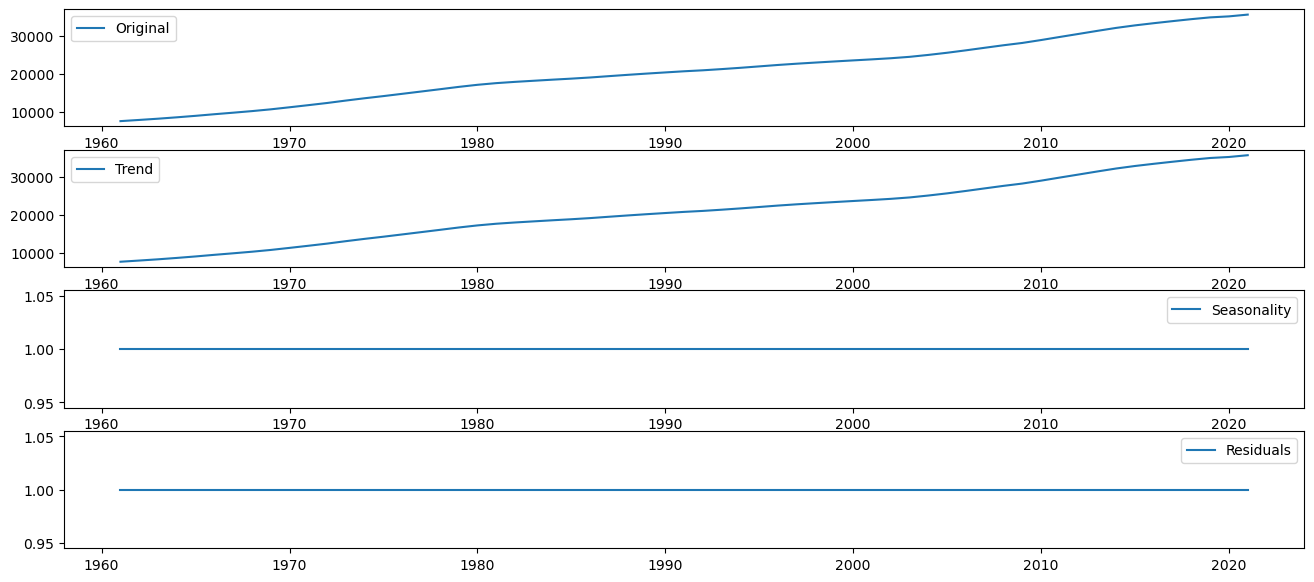

In [68]:
#visualizing the trend, seasonality and residuals of the time series
decomposition = seasonal_decompose(glob_total_temp2,period=1,model = 'multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(glob_total_temp2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

**No seasonality and no residuals, original model explained by trend only**

/Users/hairong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/hairong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/hairong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



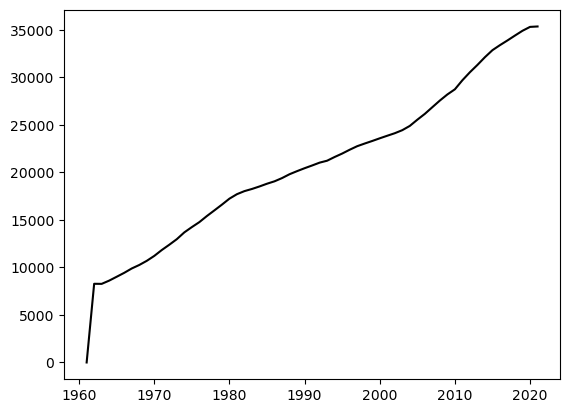

In [69]:
#building the model on covariance stationery data
# Build ARIMA model
model = ARIMA(glob_total_temp2, order=(2, 1, 2))
results_ARIMA = model.fit()

# Plot the fitted values
plt.plot(results_ARIMA.fittedvalues, color='black')
plt.show()

In [70]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

Year
1961       0.000000
1962    8280.622591
1963    8272.791765
1964    8614.529260
1965    9021.581465
dtype: float64


In [71]:
#reversing what we did earlier, i.e shifting by 12 time priods
ARIMA_shifted= ARIMA_diff_predictions.shift(periods=12).dropna()

In [72]:
ARIMA_shifted

Year
1973        0.000000
1974     8280.622591
1975     8272.791765
1976     8614.529260
1977     9021.581465
1978     9433.681435
1979     9891.627763
1980    10258.974389
1981    10695.982485
1982    11215.475300
1983    11833.913138
1984    12391.430850
1985    12977.163881
1986    13692.324537
1987    14247.104822
1988    14771.061436
1989    15410.564316
1990    16006.230958
1991    16609.487217
1992    17239.338348
1993    17710.578080
1994    18033.207436
1995    18260.135412
1996    18523.729954
1997    18811.740877
1998    19064.965037
1999    19405.152950
2000    19810.711360
2001    20135.489258
2002    20442.354887
2003    20729.603267
2004    21029.703076
2005    21234.327213
2006    21624.251875
2007    21984.673140
2008    22387.183996
2009    22760.319776
2010    23040.933704
2011    23308.937615
2012    23590.185944
2013    23860.225645
2014    24125.151488
2015    24445.893641
2016    24894.716927
2017    25546.209215
2018    26161.488063
2019    26864.866202
2020    

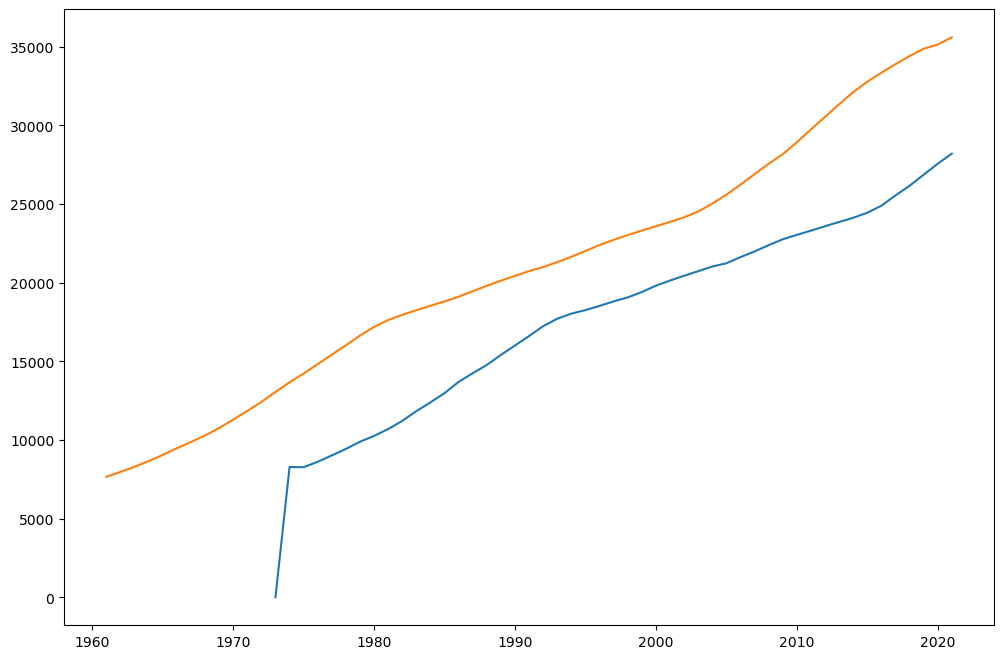

In [73]:
#visualizing actual and predicted results
plt.figure(figsize=(12,8))
plt.plot(ARIMA_shifted)
plt.plot(glob_total_temp2)

**Out Model does good in predicting the trends over time**